#### imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
#import pyshark
import utils as ut
#from scapy.all import rdcap
#import dpkt
#from sklearn import test_train_split, random_forest
import re

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Conv1D, MaxPooling1D
import tensorflow as tf
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

---

#### data
https://www.kaggle.com/datasets/advaitnmenon/network-traffic-data-malicious-activity-detection

#### new data set potentially

https://www.stratosphereips.org/datasets-iot23

##### tensorflow example
https://www.freecodecamp.org/news/binary-classification-made-simple-with-tensorflow/

---

### Reading in the data and data exploration

In [3]:
os.getcwd()

'C:\\Users\\speco\\USD\\intro_to_ai\\team-8\\spencer'

In [4]:
example_data = r"data\labeled_pcap_output\conn.log.labeled"


final_df = ut.read_and_parse_label_file(example_data)

C:\Users\speco\USD\intro_to_ai\team-8\spencer\utils.py:5: DtypeWarning: Columns (0,3,5,14,16,17,18,19,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_label_file,


In [10]:
final_df[:2]

ts                 uid        id.orig_h id.orig_p  \
1  1525879831.015811  CUmrqr4svHuSXJy5z7  192.168.100.103     51524   
2  1525879831.025055  CH98aB3s1kJeq6SFOc  192.168.100.103     56305   

        id.resp_h id.resp_p proto service  duration orig_bytes  ...  \
1  65.127.233.163        23   tcp       -  2.999051          0  ...   
2   63.150.16.171        23   tcp       -         -          -  ...   

  local_resp missed_bytes history orig_pkts orig_ip_bytes resp_pkts  \
1          -            0       S         3           180         0   
2          -            0       S         1            60         0   

  resp_ip_bytes tunnel_parents       label              detailed-label  
1             0        (empty)   Malicious   PartOfAHorizontalPortScan  
2             0        (empty)   Malicious   PartOfAHorizontalPortScan  

[2 rows x 23 columns]

In [11]:
final_df.columns

Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history',
       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes',
       'tunnel_parents', 'label', 'detailed-label'],
      dtype='object')

In [12]:
final_df['detailed-label'].unique()

array([' PartOfAHorizontalPortScan', ' -', ' C&C'], dtype=object)

In [13]:
final_df.missed_bytes

1            0
2            0
3            0
4            0
5            0
          ... 
1008744    0.0
1008745    0.0
1008746    0.0
1008747    0.0
1008748    0.0
Name: missed_bytes, Length: 1008748, dtype: object

In [14]:
columns_to_remove = ['ts', 'uid', 'id.orig_h', 'id.resp_h', 'local_orig', 'local_resp', 'tunnel_parents', 'detailed-label']

In [15]:
columns_to_keep = []
for col in list(final_df.columns):
    if col not in columns_to_remove:
        columns_to_keep.append(col)

In [16]:
columns_to_keep

['id.orig_p',
 'id.resp_p',
 'proto',
 'service',
 'duration',
 'orig_bytes',
 'resp_bytes',
 'conn_state',
 'missed_bytes',
 'history',
 'orig_pkts',
 'orig_ip_bytes',
 'resp_pkts',
 'resp_ip_bytes',
 'label']

In [17]:
df = final_df[columns_to_keep].copy()

In [18]:
df.orig_bytes.unique()

array(['0', '-', '48', '180', '120', '400', '80', '220', '440', '56',
       '18', '360', '260', '62', '64', '66', '60', '63', '65', '72', '61',
       '55', '73', '70', '67', '68', '69', '57', '58', '79', '59', '78',
       '81', '85', '77', '75', '74', '83', '76', '92', '71', '88', '110',
       '51', '41', '52', '53', '54', '50', '49', '47', '44', '43', '300',
       '46', '45', '104', '86', '84', '90', '87', '82', '93', '89', '96',
       '97', '94', '91', '103', '95', '109', '31', '129', '42', '114',
       '133', '102', '123', '113', '101', '112', '107', '122', '121',
       '170', '98', '176', '39', '108', '128', '115', '127', '117', '160',
       '106', '124', '40', '136', '139', '118', '155', '105', '340',
       '100', '116', '99', '111', '119', '125', '240', '620', '32', '30',
       '33', '26', '34', '29', '36', '35', '28', '37', '38', '24', '156',
       '580', '140', '920', '168', '720', '288', '800', '132', '9', '336',
       '12', '3', '15', '27', '480', '1533', '1536',

In [19]:
df[['orig_bytes', 'resp_bytes', 'duration']] = df[['orig_bytes', 'resp_bytes', 'duration']].replace({'-': -1})

In [20]:
df

id.orig_p id.resp_p proto service  duration orig_bytes resp_bytes  \
1           51524        23   tcp       -  2.999051          0          0   
2           56305        23   tcp       -        -1         -1         -1   
3           41101        23   tcp       -        -1         -1         -1   
4           60905        23   tcp       -  2.998796          0          0   
5           44301        23   tcp       -        -1         -1         -1   
...           ...       ...   ...     ...       ...        ...        ...   
1008744   43763.0   64906.0   udp       -        -1         -1         -1   
1008745   43763.0   39435.0   udp       -        -1         -1         -1   
1008746   43763.0   26169.0   udp       -        -1         -1         -1   
1008747   43763.0   18241.0   udp       -        -1         -1         -1   
1008748   43763.0   16854.0   udp       -        -1         -1         -1   

        conn_state missed_bytes history orig_pkts orig_ip_bytes resp_pkts  \
1               S0            0       S         3           180         0   
2               S0            0       S         1            60         0   
3               S0            0       S         1            60         0   
4               S0            0       S         3           180         0   
5               S0            0       S         1            60         0   
...            ...          ...     ...       ...           ...       ...   
1008744         S0          0.0       D       1.0          40.0       0.0   
1008745         S0          0.0       D       1.0          40.0       0.0   
1008746         S0          0.0       D       1.0          40.0       0.0   
1008747         S0          0.0       D       1.0          40.0       0.0   
1008748         S0          0.0       D       1.0          40.0       0.0   

        resp_ip_bytes       label  
1                   0   Malicious  
2                   0   Malicious  
3                   0   Malicious  
4                   0   Malicious  
5                   0   Malicious  
...               ...         ...  
1008744           0.0      Benign  
1008745           0.0      Benign  
1008746           0.0      Benign  
1008747           0.0      Benign  
1008748           0.0      Benign  

[1008748 rows x 15 columns]

In [21]:
#df.duration.astype(float)

In [22]:
data_type_map = {
    'id.orig_p': int,
    'id.resp_p': int,
    'proto': str,
    'service': str,
    'duration': float,
    'orig_bytes': int,
    'resp_bytes': int,
    'conn_state': str,
    'missed_bytes': int,
    'history': str,
    'orig_pkts': int,
    'orig_ip_bytes': int,
    'resp_pkts': int,
    'resp_ip_bytes': int,
    'label':str
}

In [23]:
df = df.astype(data_type_map)

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
len(df)

1008748

In [27]:
target = 'label'


X =  df.loc[:, df.columns != target].copy()
y = df[[target]].replace({' Malicious': 1,
                        ' Benign': 0})

C:\Users\speco\AppData\Local\Temp\ipykernel_4156\1853006761.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df[[target]].replace({' Malicious': 1,


In [28]:
X.conn_state.unique()

array(['S0', 'REJ', 'SF', 'OTH', 'RSTOS0', 'RSTR', 'S2', 'RSTRH', 'RSTO',
       'S1', 'SH'], dtype=object)

In [29]:
from sklearn.preprocessing import LabelEncoder

In [30]:

le = LabelEncoder()


encoded_data = le.fit_transform(X.conn_state)

X['conn_state'] = encoded_data

In [31]:
le = LabelEncoder()


encoded_data = le.fit_transform(X.proto)

X['proto'] = encoded_data

In [32]:
le = LabelEncoder()


encoded_data = le.fit_transform(X.service)

X['service'] = encoded_data

In [33]:
le = LabelEncoder()


encoded_data = le.fit_transform(X.history)

X['history'] = encoded_data

In [34]:
X[['proto', 'service', 'conn_state', 'history']]

proto  service  conn_state  history
1            1        0           6       22
2            1        0           6       22
3            1        0           6       22
4            1        0           6       22
5            1        0           6       22
...        ...      ...         ...      ...
1008744      2        0           6        2
1008745      2        0           6        2
1008746      2        0           6        2
1008747      2        0           6        2
1008748      2        0           6        2

[1008748 rows x 4 columns]

In [35]:
X

id.orig_p  id.resp_p  proto  service  duration  orig_bytes  \
1            51524         23      1        0  2.999051           0   
2            56305         23      1        0 -1.000000          -1   
3            41101         23      1        0 -1.000000          -1   
4            60905         23      1        0  2.998796           0   
5            44301         23      1        0 -1.000000          -1   
...            ...        ...    ...      ...       ...         ...   
1008744      43763      64906      2        0 -1.000000          -1   
1008745      43763      39435      2        0 -1.000000          -1   
1008746      43763      26169      2        0 -1.000000          -1   
1008747      43763      18241      2        0 -1.000000          -1   
1008748      43763      16854      2        0 -1.000000          -1   

         resp_bytes  conn_state  missed_bytes  history  orig_pkts  \
1                 0           6             0       22          3   
2                -1           6             0       22          1   
3                -1           6             0       22          1   
4                 0           6             0       22          3   
5                -1           6             0       22          1   
...             ...         ...           ...      ...        ...   
1008744          -1           6             0        2          1   
1008745          -1           6             0        2          1   
1008746          -1           6             0        2          1   
1008747          -1           6             0        2          1   
1008748          -1           6             0        2          1   

         orig_ip_bytes  resp_pkts  resp_ip_bytes  
1                  180          0              0  
2                   60          0              0  
3                   60          0              0  
4                  180          0              0  
5                   60          0              0  
...                ...        ...            ...  
1008744             40          0              0  
1008745             40          0              0  
1008746             40          0              0  
1008747             40          0              0  
1008748             40          0              0  

[1008748 rows x 14 columns]

In [36]:
y

label
1            1
2            1
3            1
4            1
5            1
...        ...
1008744      0
1008745      0
1008746      0
1008747      0
1008748      0

[1008748 rows x 1 columns]

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X

id.orig_p  id.resp_p  proto  service  duration  orig_bytes  \
1            51524         23      1        0  2.999051           0   
2            56305         23      1        0 -1.000000          -1   
3            41101         23      1        0 -1.000000          -1   
4            60905         23      1        0  2.998796           0   
5            44301         23      1        0 -1.000000          -1   
...            ...        ...    ...      ...       ...         ...   
1008744      43763      64906      2        0 -1.000000          -1   
1008745      43763      39435      2        0 -1.000000          -1   
1008746      43763      26169      2        0 -1.000000          -1   
1008747      43763      18241      2        0 -1.000000          -1   
1008748      43763      16854      2        0 -1.000000          -1   

         resp_bytes  conn_state  missed_bytes  history  orig_pkts  \
1                 0           6             0       22          3   
2                -1           6             0       22          1   
3                -1           6             0       22          1   
4                 0           6             0       22          3   
5                -1           6             0       22          1   
...             ...         ...           ...      ...        ...   
1008744          -1           6             0        2          1   
1008745          -1           6             0        2          1   
1008746          -1           6             0        2          1   
1008747          -1           6             0        2          1   
1008748          -1           6             0        2          1   

         orig_ip_bytes  resp_pkts  resp_ip_bytes  
1                  180          0              0  
2                   60          0              0  
3                   60          0              0  
4                  180          0              0  
5                   60          0              0  
...                ...        ...            ...  
1008744             40          0              0  
1008745             40          0              0  
1008746             40          0              0  
1008747             40          0              0  
1008748             40          0              0  

[1008748 rows x 14 columns]

In [39]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                    test_size=0.2, 
                                                    )

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import load_iris

In [306]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

C:\Users\speco\anaconda3\envs\python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 99.99%


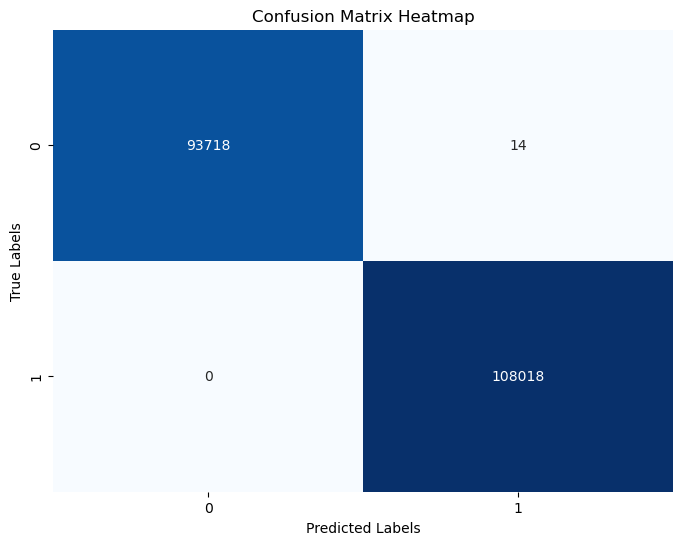

In [312]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            #xticklabels=iris.target_names, 
            #yticklabels=iris.target_names
           )

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### SVM model

### Final reformated dataframe

In [8]:
final_df[:1]

ts                 uid        id.orig_h id.orig_p  \
1  1525879831.015811  CUmrqr4svHuSXJy5z7  192.168.100.103     51524   

        id.resp_h id.resp_p proto service  duration orig_bytes  ...  \
1  65.127.233.163        23   tcp       -  2.999051          0  ...   

  local_resp missed_bytes history orig_pkts orig_ip_bytes resp_pkts  \
1          -            0       S         3           180         0   

  resp_ip_bytes tunnel_parents       label              detailed-label  
1             0        (empty)   Malicious   PartOfAHorizontalPortScan  

[1 rows x 23 columns]

In [9]:
len(final_df)

1008748

In [3]:
raw_pcap = r"C:\Users\speco\USD\intro_to_ai\team-8\spencer\data\labeled_pcap_output\Malware_1_Hexdump.csv"

In [4]:
raw_packets = pd.read_csv(raw_pcap)

In [20]:
raw_packets[:1]

Unnamed: 0    epoch_time                                            hexdump
0           0  1.525880e+09  0000  78 8A 20 43 93 D5 B8 27 EB C7 E9 C9 08 0...

In [13]:
ex_dump = raw_packets.hexdump.iloc[0]

In [18]:
print(ex_dump)

0000  78 8A 20 43 93 D5 B8 27 EB C7 E9 C9 08 00 45 00  x. C...'......E.
0010  00 28 61 D3 40 00 40 11 BB 98 C0 A8 64 67 9A 08  .(a.@.@.....dg..
0020  5E 41 AA F3 38 00 00 14 A4 E5 51 FF 85 59 90 25  ^A..8.....Q..Y.%
0030  25 3F 9A 3B 33 9A 00 00 00 00 00 00              %?.;3.......


In [19]:
np.array(get_byte_list(ex_dump))

array([120, 138,  32,  67, 147, 213, 184,  39, 235, 199, 233, 201,   8,
         0,  69,   0,   0,  40,  97, 211,  64,   0,  64,  17, 187, 152,
       192, 168, 100, 103, 154,   8,  94,  65, 170, 243,  56,   0,   0,
        20, 164, 229,  81, 255, 133,  89, 144,  37,  37,  63, 154,  59,
        51, 154,   0,   0,   0,   0,   0,   0])

In [13]:
raw_packets.rename(columns = {'epoch_time': 'ts'}, inplace = True)

In [14]:
final_df['ts'] = final_df.ts.astype(float)

In [15]:
merge_df = raw_packets.merge(final_df, 
                  on = 'ts', 
                  how = 'outer', 
                  indicator = True
                 )

In [15]:
hex_conversion = {
    "0":0,
    "1":1,
    "2":2,
    "3":3,
    "4":4,
    "5":5,
    "6":6,
    "7":7,
    "8":8,
    "9":9,
    "A":10,
    "B":11,
    "C":12,
    "D":13,
    "E":14,
    "F":15
}

In [6]:
def convert_hex_to_dec(hex_num:str)->int:
    byte_d = 0

    for i, b in enumerate(hex_num, 1):
        decimal_position = len(hex_num) - i
        b_to_d = hex_conversion[b]
        value = b_to_d * 16**decimal_position
        byte_d +=value
        
    return int(byte_d)


In [7]:
def get_byte_list(byte_str)->list:
    real_byte = []

    for byte in byte_str.split(' '):
        match = re.match(r"^[A-Fa-f0-9]+$", byte)

        if (len(byte) == 2) and match:

            decimal_byte = convert_hex_to_dec(byte)

            real_byte.append(decimal_byte)
            
    return real_byte

In [42]:
byte = '1A4'

In [43]:
convert_hex_to_dec(byte)

420

In [44]:
complete_data_df = merge_df[merge_df._merge == 'both'].copy()

In [52]:
def setup_raw_bytes_df(df:pd.DataFrame)->pd.DataFrame:
    df_index_ts = []
    list_of_lists = []
    
    
    for ts, hexdump in zip(df.ts, df.hexdump):
        
        df_index_ts.append(ts)
        list_of_bytes = get_byte_list(hexdump)
        
        list_of_lists.append(list_of_bytes)

    raw_df = pd.DataFrame(index = df_index_ts, data = list_of_lists)
    raw_df['label'] = df.label.tolist()
    raw_df = raw_df.reset_index().rename(columns = {'index':'ts'})

    return raw_df

In [53]:
complete_data_df = complete_data_df[['ts', 'hexdump', 'label']].copy()

In [140]:
raw_df = setup_raw_bytes_df(complete_data_df[:100_000])

In [141]:
raw_df[:1]

ts    0    1   2   3    4    5    6   7    8  ...  173  174  175  \
0  1.525880e+09  120  138  32  67  147  213  184  39  235  ...  NaN  NaN  NaN   

   176  177  178  179  180  181    label  
0  NaN  NaN  NaN  NaN  NaN  NaN   Benign  

[1 rows x 184 columns]

In [142]:
raw_df.to_csv('truncated_100_000_initial_attempt_to_setup_data.csv', index = False)

In [5]:
raw_df = pd.read_csv('truncated_100_000_initial_attempt_to_setup_data.csv')

In [25]:
columns_to_show = []

for c in raw_df.columns[:11]:
    columns_to_show.append(c)

columns_to_show.append('label')

In [27]:
raw_df.loc[0:3, columns_to_show]

ts    0    1   2   3    4    5    6   7    8    9       label
0  1.525880e+09  120  138  32  67  147  213  184  39  235  199      Benign
1  1.525880e+09  120  138  32  67  147  213  184  39  235  199   Malicious
2  1.525880e+09  120  138  32  67  147  213  184  39  235  199   Malicious
3  1.525880e+09  120  138  32  67  147  213  184  39  235  199   Malicious

In [6]:
X = raw_df.drop(columns=['ts', 'label']).copy()
y = raw_df.label.replace({' Benign':0,
                          ' Malicious':1
                         })

C:\Users\speco\AppData\Local\Temp\ipykernel_3944\851838502.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = raw_df.label.replace({' Benign':0,


In [7]:
raw_df.groupby('label').count().ts

label
Benign       44985
Malicious    55015
Name: ts, dtype: int64

In [8]:
y.unique()

array([0, 1], dtype=int64)

In [9]:
X.fillna(int(0), inplace=True)

In [10]:
X.head()

0    1   2   3    4    5    6   7    8    9  ...  172  173  174  175  \
0  120  138  32  67  147  213  184  39  235  199  ...  0.0  0.0  0.0  0.0   
1  120  138  32  67  147  213  184  39  235  199  ...  0.0  0.0  0.0  0.0   
2  120  138  32  67  147  213  184  39  235  199  ...  0.0  0.0  0.0  0.0   
3  120  138  32  67  147  213  184  39  235  199  ...  0.0  0.0  0.0  0.0   
4  120  138  32  67  147  213  184  39  235  199  ...  0.0  0.0  0.0  0.0   

   176  177  178  179  180  181  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 182 columns]

In [149]:
X.shape

(100000, 182)

In [11]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                    test_size=0.2, 
                                                    random_state=37
                                                   )

### setting up the model

In [13]:
input_shape = X_train.shape[1]

In [14]:
input_shape

182

In [ ]:
### basic model

# model = Sequential()

# model.add(Dense(units=16, activation='relu', input_shape=(input_shape,)))
# model.add(Dense(1, activation='sigmoid'))



article followed for code
https://medium.com/@mayankverma05032001/binary-classification-using-convolution-neural-network-cnn-model-6e35cdf5bdbb

In [15]:
model = Sequential()
kernel = (3)
model.add(Conv1D(32, kernel_size = kernel, activation = 'relu', input_shape=(input_shape,1)))
model.add(Conv1D(64, kernel_size = kernel, activation = 'relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(64, kernel_size = kernel, activation = 'relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(128, kernel_size = kernel, activation = 'relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [16]:
adam = keras.optimizers.Adam(learning_rate=0.001)

In [17]:
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 180, 32)           128       
                                                                 
 conv1d_1 (Conv1D)           (None, 178, 64)           6208      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 89, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 89, 64)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 87, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 43, 64)           0         
 1D)                                                  

In [22]:
input_shapes = [(2 * k, 2 * k, 3) for k in range(2, 6)]

for input_shape in input_shapes:
    print(f'input shape = ', input_shape)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=input_shape))
    model.add(tf.keras.layers.Conv2D(10, kernel_size=3, use_bias=True))
    model.summary() # The total number of parameters is always 280
    print('')
    print('_______________________________________________________')

input shape =  (4, 4, 3)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 2, 2, 10)          280       
                                                                 
Total params: 280
Trainable params: 280
Non-trainable params: 0
_________________________________________________________________

_______________________________________________________
input shape =  (6, 6, 3)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 4, 4, 10)          280       
                                                                 
Total params: 280
Trainable params: 280
Non-trainable params: 0
_________________________________________________________________

_______________________________________________________
in

### training the model

In [162]:
model_history = model.fit(X_train, y_train, epochs = 50)

Epoch 1/50
2500/2500 [==============================] - 78s 31ms/step - loss: 0.0808 - accuracy: 0.9776
Epoch 2/50
2500/2500 [==============================] - 77s 31ms/step - loss: 0.0385 - accuracy: 0.9925
Epoch 3/50
2500/2500 [==============================] - 79s 32ms/step - loss: 0.0335 - accuracy: 0.9936
Epoch 4/50
2500/2500 [==============================] - 78s 31ms/step - loss: 0.0288 - accuracy: 0.9943
Epoch 5/50
2500/2500 [==============================] - 73s 29ms/step - loss: 0.0244 - accuracy: 0.9954
Epoch 6/50
2500/2500 [==============================] - 75s 30ms/step - loss: 0.0229 - accuracy: 0.9956
Epoch 7/50
2500/2500 [==============================] - 80s 32ms/step - loss: 0.0193 - accuracy: 0.9962
Epoch 8/50
2500/2500 [==============================] - 76s 30ms/step - loss: 0.0193 - accuracy: 0.9962
Epoch 9/50
2500/2500 [==============================] - 71s 29ms/step - loss: 0.0158 - accuracy: 0.9967
Epoch 10/50
2500/2500 [==============================] - 77s 31m

In [163]:
model.save("cnn_model_100_000_samples.keras")

#### evaluating the model

In [164]:
loss_and_metrics = model.evaluate(X_test, y_test)

625/625 [==============================] - 6s 9ms/step - loss: 0.0064 - accuracy: 0.9986


In [165]:
print(f'Loss = {loss_and_metrics[0]}')
print(f'Accuracy = {loss_and_metrics[1]}')

Loss = 0.00640022661536932
Accuracy = 0.9986000061035156


In [166]:
predicted = model.predict(X_test)

625/625 [==============================] - 6s 9ms/step


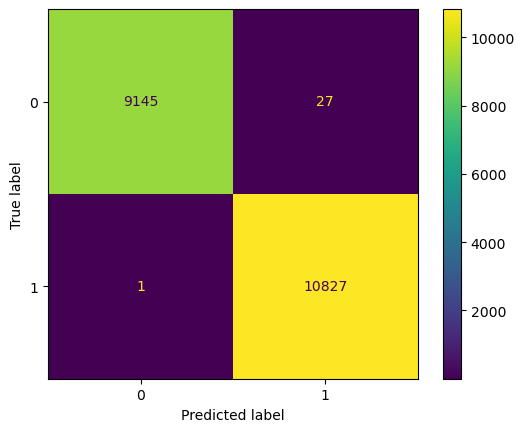

In [167]:
predicted = tf.squeeze(predicted)
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(y_test)
conf_mat = confusion_matrix(actual, predicted)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

---
---
---

In [25]:
pcap_path = r'data/new_data_dale_selection/dale/2018-09-21-capture.pcap'

In [33]:
from dpkt.utils import mac_to_str, inet_to_str
import datetime

In [34]:
packets = dpkt.pcap.Reader(open(pcap_path,'rb'))

In [35]:

parsed_data = {
    'index': [],
    'ts': [],
    'eth.src': [],
    'eth.dst': [],
    'eth.type':[],
    'eth.data':[],
    'ip.src':[],
    'ip.dst':[],
    'ip.len':[],
    'ip.ttl':[],
    'ip.df': [],
    'ip.mf': [],
    
    
}




for timestamp, buf in packets:
    
    #ts

    # Print out the timestamp in UTC
    print('Timestamp: ', str(datetime.datetime.utcfromtimestamp(timestamp)))

    # Unpack the Ethernet frame (mac src/dst, ethertype)
    eth = dpkt.ethernet.Ethernet(buf)
    print('Ethernet Frame: ', mac_to_str(eth.src), mac_to_str(eth.dst), eth.type)

    # Make sure the Ethernet frame contains an IP packet
    if not isinstance(eth.data, dpkt.ip.IP):
        print('Non IP Packet type not supported %s\n' % eth.data.__class__.__name__)
        continue

    # Now access the data within the Ethernet frame (the IP packet)
    # Pulling out src, dst, length, fragment info, TTL, and Protocol
    ip = eth.data

    # Print out the info, including the fragment flags and offset
    print('IP: %s -> %s   (len=%d ttl=%d DF=%d MF=%d offset=%d)\n' %
          (inet_to_str(ip.src), inet_to_str(ip.dst), ip.len, ip.ttl, ip.df, ip.mf, ip.offset))

Timestamp:  2018-09-21 09:40:22.965530
Ethernet Frame:  80:e6:50:21:86:7c ff:ff:ff:ff:ff:ff 2048
IP: 0.0.0.0 -> 255.255.255.255   (len=328 ttl=255 DF=0 MF=0 offset=0)

Timestamp:  2018-09-21 09:40:26.845520
Ethernet Frame:  82:e6:50:12:14:64 ff:ff:ff:ff:ff:ff 2048
IP: 192.168.2.1 -> 192.168.2.255   (len=72 ttl=64 DF=0 MF=0 offset=0)

Timestamp:  2018-09-21 09:40:31.287918
Ethernet Frame:  80:e6:50:21:86:7c ff:ff:ff:ff:ff:ff 2048
IP: 0.0.0.0 -> 255.255.255.255   (len=328 ttl=255 DF=0 MF=0 offset=0)

Timestamp:  2018-09-21 09:40:56.849668
Ethernet Frame:  82:e6:50:12:14:64 ff:ff:ff:ff:ff:ff 2048
IP: 192.168.2.1 -> 192.168.2.255   (len=72 ttl=64 DF=0 MF=0 offset=0)

Timestamp:  2018-09-21 09:41:26.873854
Ethernet Frame:  82:e6:50:12:14:64 ff:ff:ff:ff:ff:ff 2048
IP: 192.168.2.1 -> 192.168.2.255   (len=72 ttl=64 DF=0 MF=0 offset=0)

Timestamp:  2018-09-21 09:41:37.732295
Ethernet Frame:  82:e6:50:12:14:64 01:00:5e:00:00:fb 2048
IP: 192.168.2.1 -> 224.0.0.251   (len=391 ttl=255 DF=0 MF=0 off

In [ ]:
packets = rdpcap(pcap_path)

In [26]:
capture = pyshark.FileCapture(pcap_path)

C:\Users\speco\anaconda3\lib\site-packages\pyshark\capture\capture.py:177: UserWarning: The running eventloop has tasks but pyshark must set a new eventloop to continue. Existing tasks may not run.
  warnings.warn("The running eventloop has tasks but pyshark must set a new eventloop to continue. "


In [27]:
capture[0]

RuntimeError: Cannot run the event loop while another loop is running

In [ ]:
# potential columns to drop
# local_orig
# local_resp
# tunnel parents
# detail-label

In [107]:
final_df['detailed-label']

1       -
2       -
3       -
4       -
5       -
       ..
126     -
127     -
128     -
129     -
130     -
Name: detailed-label, Length: 130, dtype: object

In [108]:
final_df['ts'] = final_df.ts.astype(float)
final_df['duration'] = final_df.duration.astype(float)
final_df['orig_bytes'] = final_df.orig_bytes.astype(int)
final_df['resp_bytes'] = final_df.resp_bytes.astype(int)
final_df['missed_bytes'] = final_df.missed_bytes.astype(int)
final_df['orig_pkts'] = final_df.orig_pkts.astype(int)
final_df['orig_ip_bytes'] = final_df.orig_ip_bytes.astype(int)
final_df['resp_pkts'] = final_df.resp_pkts.astype(int)
final_df['resp_ip_bytes'] = final_df.resp_ip_bytes.astype(int)

In [121]:
final_df.ts

1      1.562160e+09
2      1.562160e+09
3      1.562160e+09
4      1.562160e+09
5      1.562160e+09
           ...     
126    1.562165e+09
127    1.562165e+09
128    1.562165e+09
129    1.562165e+09
130    1.562165e+09
Name: ts, Length: 130, dtype: float64

In [122]:
final_df['id.orig_h'].unique()

array(['0.0.0.0', '255.255.255.255', 'fe80::5bcc:698e:39d5:cdf',
       'fe80::4eef:c0ff:fe27:561e', '::', '192.168.1.158', '192.168.4.2',
       'fe80::6a05:71ff:fe67:dff2', '192.168.1.1',
       'fe80::18:e207:b314:641b', 'fe80::211:32ff:fe8d:ffe2'],
      dtype=object)

In [109]:
final_df.dtypes

ts                float64
uid                object
id.orig_h          object
id.orig_p          object
id.resp_h          object
id.resp_p          object
proto              object
service            object
duration          float64
orig_bytes          int32
resp_bytes          int32
conn_state         object
local_orig         object
local_resp         object
missed_bytes        int32
history            object
orig_pkts           int32
orig_ip_bytes       int32
resp_pkts           int32
resp_ip_bytes       int32
tunnel_parents     object
label              object
detailed-label     object
dtype: object

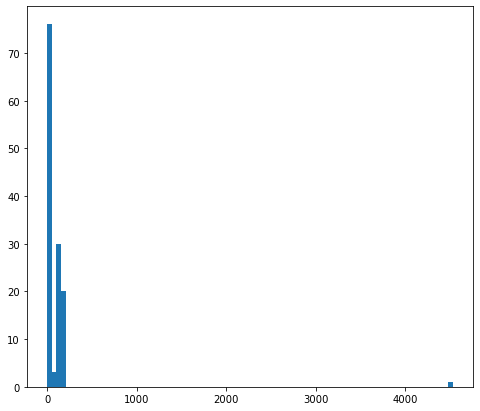

In [117]:
fig, ax = plt.subplots(figsize = (8,7))

plt.hist(final_df.duration, bins = 'auto')
#plt.xlim(0, 300)
plt.show()

In [ ]:
df.resp_ip_bytes.str.split('  ', expand = True)

In [ ]:
split_last_col = trim_cols[-1].split('   ') # 3 spaces lol

In [ ]:
trim_cols.extend(split_last_col)

In [ ]:
len(trim_cols)

In [ ]:
trimmed_df.to_csv("current df.csv", index = False)

In [ ]:
pd.DataFrame(df.groupby('Source Port')['Source Port'].count())

In [ ]:
pd.DataFrame(df.groupby('Destination').Destination.count())

In [ ]:
df.Destination.unique()

In [ ]:
df.dtypes

In [ ]:
df.corr()

In [ ]:
sns.heatmap(df.corr())

In [ ]:
sns.histplot(df, x = 'Time')

In [ ]:
df.Length.unique()

In [ ]:
df['str_length'] = df.Length.astype(str)

pd.DataFrame(df.groupby('str_length').str_length.count()).style

the string length is nearly always 42

In [ ]:
fig, ax = plt.subplots()
sns.histplot(df, 
             x = 'Length',
            binwidth = 1
            )
plt.xlim(-1, 150)

In [ ]:
df['Source Port'].unique()

In [ ]:
encoded_df = pd.get_dummies(df)

In [ ]:
encoded_df.shape

---

### random forest classifier